In [1]:
import os
import pandas as pd
from popstudies_preprocessor import build_datasets, load_curated
from popstudies_analysis import (make_word_vis, make_author_table,
                                 make_affil_plot,
                                 summarize_scrape_and_curate,
                                 gender_over_time, headline_topics,
                                 make_mwc, make_mf_topics)
%load_ext autoreload
%autoreload 2
d_path = os.path.abspath(os.path.join('..', 'data'))
figure_path = os.path.abspath(os.path.join('..', 'article',
                                           'figures'))
main_df, ref_df, auth_df = build_datasets(d_path)

In [2]:
summarize_scrape_and_curate(main_df, auth_df, ref_df, d_path)

Total number of papers in our database: 1901
Papers with no abstract: 182
There are 1858 Articles.
There are 5 Editorials.
There are 19 Erratums.
There are 2 Letters.
There are 6 Notes.
There are 11 Reviews.
Average number of authors per paper: 1.8122041031036296
Average number of references per paper: 24.76801683324566
Date of first article: 1947-01-01
Date of most recent article: 2020-09-01
Average paper length (pages): 15.44390243902439
Number of OpenAccess articles: 52


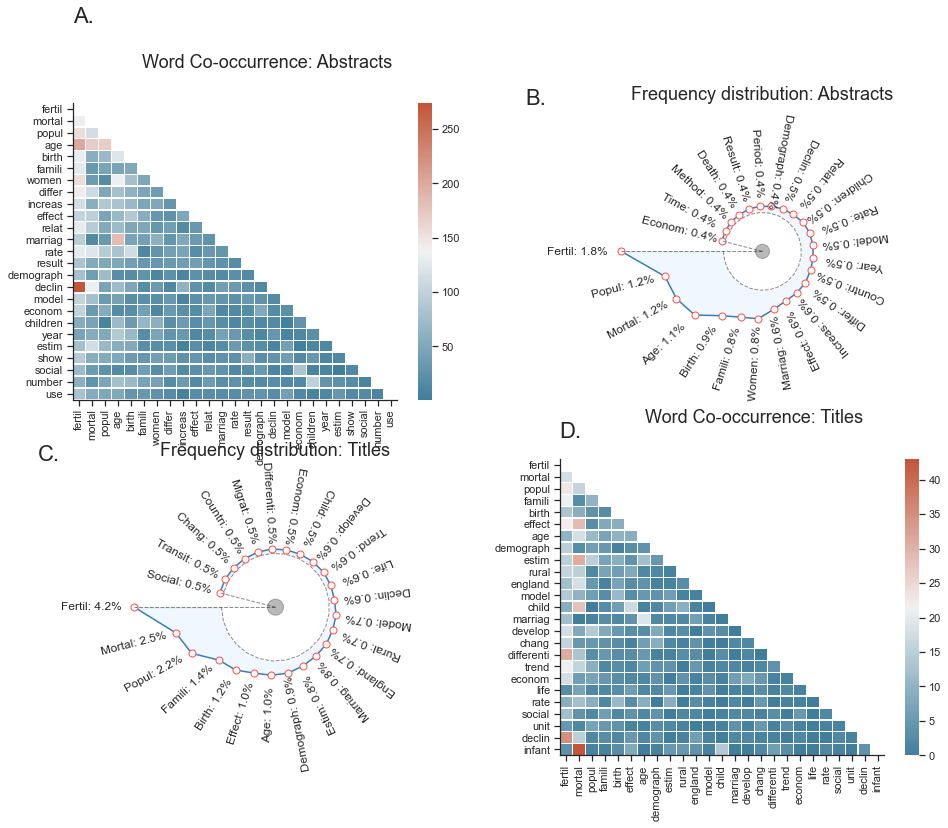

In [3]:
make_word_vis(main_df, figure_path, d_path)

In [4]:
make_author_table(auth_df, main_df, d_path, 'Papers')

                   Papers  Cites  H-Index  First  Last
fullname                                              
Robert G. Potter       20    294        9    NaN   NaN
John C. Caldwell       20   1351       13    NaN   NaN
D. V. Glass            15     78        5    NaN   NaN
John E. Knodel         15    620       11    NaN   NaN
Samuel H. Preston      14   1204       11    NaN   NaN


In [5]:
make_author_table(auth_df, main_df, d_path, 'Cites')

                   Papers  Cites  H-Index  First  Last
fullname                                              
John C. Caldwell       20   1351       13    NaN   NaN
Samuel H. Preston      14   1204       11    NaN   NaN
Larry L. Bumpass        5    801        4    NaN   NaN
Hsien Hen Lu            1    732        1    NaN   NaN
John G.F. Cleland       7    686        6    NaN   NaN


In [6]:
make_author_table(auth_df, main_df, d_path, 'H-Index')

                    Papers  Cites  H-Index  First  Last
fullname                                               
John C. Caldwell        20   1351       13    NaN   NaN
John E. Knodel          15    620       11    NaN   NaN
Samuel H. Preston       14   1204       11    NaN   NaN
Michael J. Murphy       12    383       11    NaN   NaN
Ronald F. Freedman      13    258       10    NaN   NaN


/home/porco/Dropbox/PopStudies_Review/src/popstudies_analysis.py:685: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(aff_series.index)


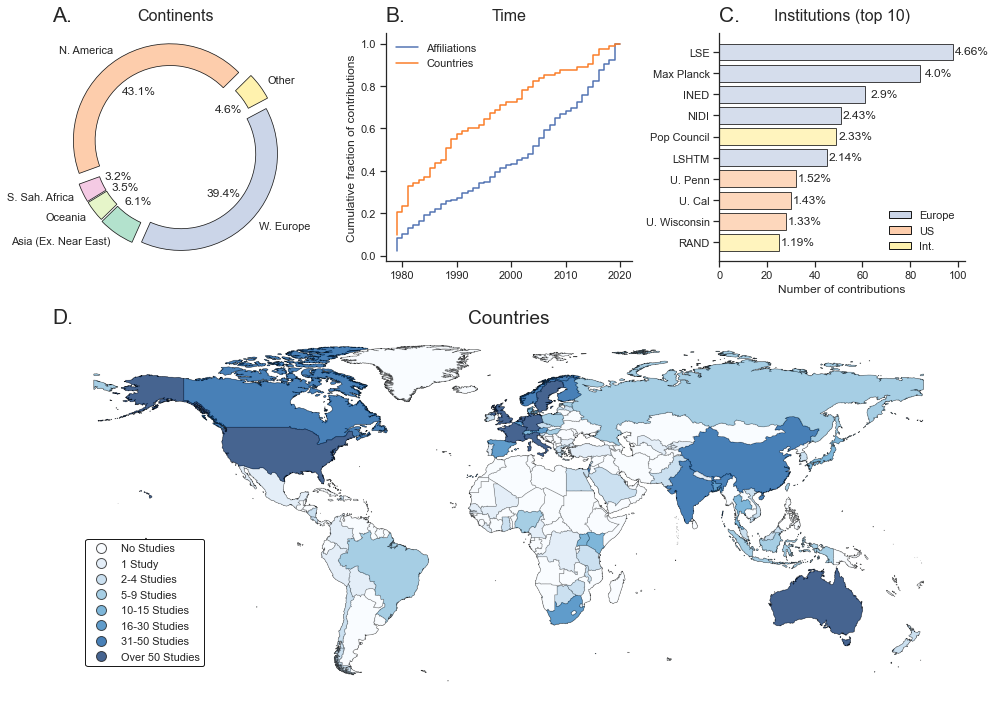

In [7]:
make_affil_plot(main_df, auth_df, d_path, figure_path)

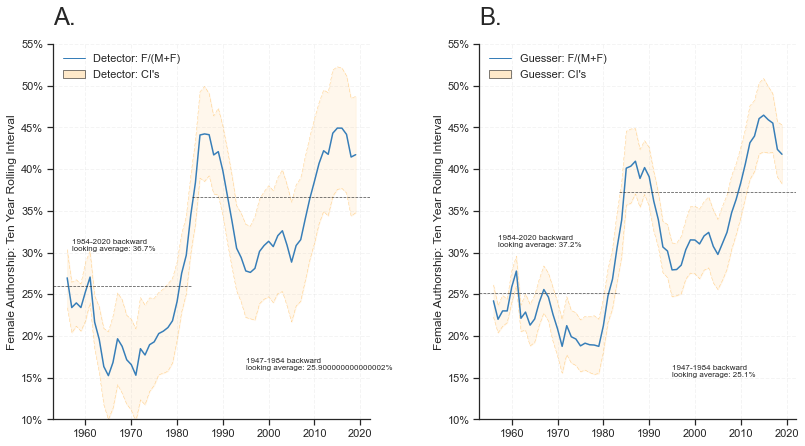

In [8]:
gender_over_time(auth_df[auth_df['forename']!='NAN'])

/home/porco/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


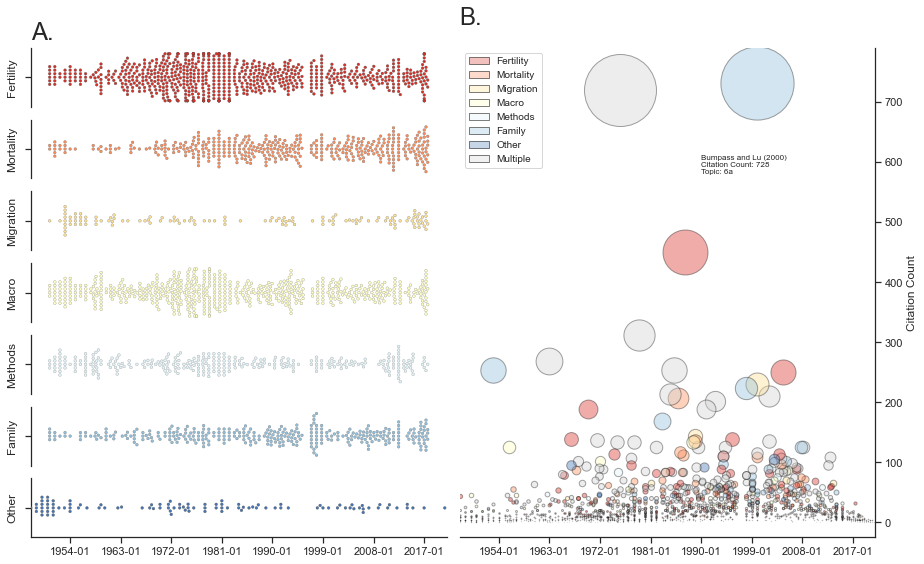

In [9]:
headline_topics(main_df)

In [10]:
main_df[main_df['Nation'].notnull()].groupby(['Nation'])['Nation'].count().sort_values(ascending=False)

Nation
United States                      108
China                               79
England; Wales                      61
India                               60
United Kingdom                      54
                                  ... 
Hungary; Sweden                      1
Taiwan; South Korea; Bangladesh      1
Holland                              1
Tibet; China                         1
Finland; Norway                      1
Name: Nation, Length: 277, dtype: int64

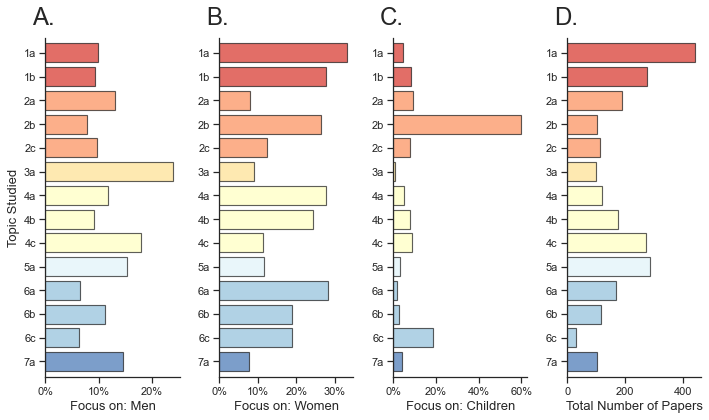

In [11]:
make_mwc(main_df)

In [12]:
make_mf_topics(auth_df[auth_df['forename']!='NAN'], main_df, d_path)

   Topic_M Subtopics_M Topic_F Subtopics_F Topic_Ratio Subtopics_Ratio
1a     564         319     275         192        2.05            1.66
1b                 245                  83                        2.95
2a     396         189     230          79        1.72            2.39
2b                  78                  52                         1.5
2c                 129                  99                         1.3
3a     104          83      62          51        1.68            1.63
3b                   6                   4                         1.5
3c                  15                   7                        2.14
4a     421          95     208          59        2.02            1.61
4b                 148                  88                        1.68
4c                 178                  61                        2.92
5a     237         237      68          68        3.49            3.49
6a     244         127     201          86        1.21            1.48
6b    

In [13]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp
import networkx as nx
import random
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.isomorphism.isomorph import (
    graph_could_be_isomorphic as isomorphic)
auth_df = auth_df[auth_df['doi'].notnull()]
author_papers = auth_df[auth_df['authorid'].notnull()]
authors_df = author_papers[['authorid', 'indexed_name']].drop_duplicates(subset=['authorid'])
int_p_id = dict(enumerate(list(author_papers['doi'].unique())))
int_a_id = dict(enumerate(list(author_papers['authorid'].unique())))
a_int_id = {authorId:intVal for intVal,authorId in int_a_id.items()}
p_int_id = {paperId:intVal for intVal,paperId in int_p_id.items()}
author_paper_tuples = list(zip(author_papers['authorid'], author_papers['doi']))
author_paper_tuples = [(a_int_id[t[0]],p_int_id[t[1]]) for t in author_paper_tuples]
AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), zip(*author_paper_tuples)))
AA = AP.dot(AP.T)
AA = np.array(AA - np.diag(AA.diagonal()))
G = nx.from_numpy_matrix(AA, parallel_edges=True)
deg_measure = nx.degree(G) 
cent_measure = nx.degree_centrality(G) 
bet_measure = nx.betweenness_centrality(G)
authors_df['degree'] = authors_df['authorid'].apply(lambda l: deg_measure[a_int_id.get(l)])
authors_df['degree_cent'] = authors_df['authorid'].apply(lambda l: cent_measure[a_int_id.get(l)])
authors_df['degree_bet'] = authors_df['authorid'].apply(lambda l: bet_measure.get(a_int_id.get(l)))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
print('Edges in entire network: ' + str(G.number_of_edges()))
print('Nodes in entire network: ' + str(G.number_of_nodes()))
print('Density of entire network: ' + str(nx.density(G)))
print('Edges in Giant Component: ' + str(G.subgraph(Gcc[0]).number_of_edges()))
print('Nodes in Giant Component: ' + str(G.subgraph(Gcc[0]).number_of_nodes()))
print('Density of Giant Component: ' + str(nx.density(G.subgraph(Gcc[0]))))

auth_df['prismcoverdate'] = auth_df['prismcoverdate'].astype('datetime64[ns]')
time_df = pd.DataFrame(index=range(1947, 2021),
                       columns=['whole_edges', 'whole_nodes', 'whole_density',
                                'giant_edges', 'giant_nodes', 'giant_density'])

for year in range(1, 75):
    year_df = auth_df[auth_df['prismcoverdate'].dt.year<1947+year]
    year_df = year_df[year_df['doi'].notnull()]
    year_author_papers = year_df[year_df['authorid'].notnull()]
    year_authors_df = year_author_papers[['authorid', 'indexed_name']].drop_duplicates(subset=['authorid'])
    int_p_id = dict(enumerate(list(year_author_papers['doi'].unique())))
    int_a_id = dict(enumerate(list(year_author_papers['authorid'].unique())))
    a_int_id = {authorId:intVal for intVal,authorId in int_a_id.items()}
    p_int_id = {paperId:intVal for intVal,paperId in int_p_id.items()}
    author_paper_tuples = list(zip(year_author_papers['authorid'], year_author_papers['doi']))
    author_paper_tuples = [(a_int_id[t[0]],p_int_id[t[1]]) for t in author_paper_tuples]
    AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), zip(*author_paper_tuples)))
    AA = AP.dot(AP.T)
    AA = np.array(AA - np.diag(AA.diagonal()))
    G = nx.from_numpy_matrix(AA, parallel_edges=True)

    time_df.loc[year+1946, 'whole_edges'] = G.number_of_edges()
    time_df.loc[year+1946, 'whole_nodes'] = G.number_of_nodes()
    time_df.loc[year+1946, 'whole_density'] = nx.density(G)
    time_df.loc[year+1946, 'giant_edges'] = G.subgraph(Gcc[0]).number_of_edges()
    time_df.loc[year+1946, 'giant_nodes'] = G.subgraph(Gcc[0]).number_of_nodes()
    time_df.loc[year+1946, 'giant_density'] = nx.density(G.subgraph(Gcc[0]))


Edges in entire network: 2317
Nodes in entire network: 2026
Density of entire network: 0.0011295138508037488
Edges in Giant Component: 926
Nodes in Giant Component: 433
Density of Giant Component: 0.009900778376528955


<ipython-input-14-61c22bd0f115>:39: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(fig_path, 'networks.pdf'),
<ipython-input-14-61c22bd0f115>:39: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(fig_path, 'networks.pdf'),
<ipython-input-14-61c22bd0f115>:41: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(fig_path, 'networks.png'),
<ipython-input-14-61c22bd0f115>:43: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(fig_path, 'networks.svg'),
/home/porco/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot mak

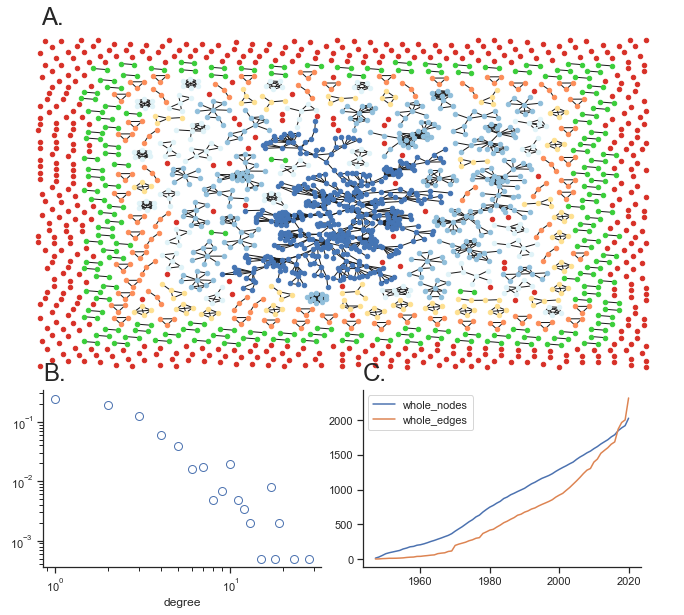

In [14]:
fig = plt.figure(figsize=(12, 10), tight_layout=True)
ax1 = plt.subplot2grid((15, 19), (0, 0), rowspan=10, colspan=20)
ax2 = plt.subplot2grid((15, 19), (10, 1), rowspan=5, colspan=8)
ax3 = plt.subplot2grid((15, 19), (10, 10), rowspan=5, colspan=8)
pos = graphviz_layout(G, prog="neato")
C = (G.subgraph(c) for c in nx.connected_components(G))
colors1 = ['#d73027', '#3ace3a', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
for g in C:
    c = [random.random()] * nx.number_of_nodes(g)  # random color...
    if nx.number_of_nodes(g) == 1:
        c = colors1[0]
    elif nx.number_of_nodes(g) == 2:
        c = colors1[1]
    elif nx.number_of_nodes(g) == 3:
        c = colors1[2]
    elif nx.number_of_nodes(g) == 4:
        c = colors1[3]
    elif (nx.number_of_nodes(g)>4) and nx.number_of_nodes(g)<8:
        c = colors1[4]
    elif (nx.number_of_nodes(g)>7) and nx.number_of_nodes(g)<400:
        c = colors1[5]
    elif (nx.number_of_nodes(g)>400):
        c = colors1[6]
    nx.draw(g, pos, node_size=20, node_color=c, vmin=0.0, vmax=1.0, with_labels=False, ax=ax1)
ax1.set_title('A.', fontsize=24, loc='left', y=0.98, x=0.05)
ax2.set_title('B.', fontsize=24, loc='left', y=1.02, x=0.0)
ax3.set_title('C.', fontsize=24, loc='left', y=1.02, x=0.0)

temp_df = pd.DataFrame(authors_df.groupby(['degree'])['degree'].count()).rename({'degree':'count'}, axis=1)
temp_df['count'] = temp_df['count']/temp_df['count'].sum()
temp_df['count'].plot(markersize=8, marker='o', loglog=True, linewidth=0, markerfacecolor='w', ax=ax2)



time_df[['whole_nodes', 'whole_edges']][:].plot(ax=ax3)


fig_path = os.path.join(os.getcwd(), '..', 'article', 'figures')
plt.savefig(os.path.join(fig_path, 'networks.pdf'),
            bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'networks.png'),
            bbox_inches='tight', dpi=600)
plt.savefig(os.path.join(fig_path, 'networks.svg'),
            bbox_inches='tight')
sns.despine()
plt.show()